# Behavioral Cloning | End to End Learning for Self Driving Cars
**In this project, I used a deep neural network (built with [Keras](https://keras.io/)) to clone car driving behavior.**

**The dataset used to train the network is generated from [Udacity's Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim), and it consists of images taken from three different camera angles (Center - Left - Right), in addition to the steering angle, throttle, brake, and speed during each frame.**

**The network is based on NVIDIA's paper [End to End Learning for Self-Driving Cars](https://arxiv.org/pdf/1604.07316v1.pdf), which has been proven to work in this problem domain.**
## Pipeline architecture:
- **Data Loading.**
- **Data Augmentation.**
- **Data Preprocessing.**
- **Model Architecture.**
- **Model Training and Evaluation.**
- **Model Testing on the simulator.**

I'll explain each step in details below.

* importing libs 

In [1]:
# Importing Python libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import csv
import cv2
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

Using TensorFlow backend.


In [4]:
# the first step is to loading the data 
data_dir = './data/'
labels_file = './data/driving_log.csv'
def load_data(labels_file, test_size):
    """
    Display a list of images in a single figure with matplotlib.
        Parameters:
            labels_file: The labels CSV file.
            test_size: The size of the testing set.
    """
    labels = pd.read_csv(labels_file)
    X = labels[['center', 'left', 'right']].values
    y = labels['steering'].values
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid
def load_image(data_dir, image_file):
    """
    Load RGB image.
        Parameters:
            data_dir: The directory where the images are.
            image_file: The image file name.
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))
def display(image, angle, label):
    plt.imshow(image)
    plt.xlabel("Steering angle: {:.5f}".format(angle))
    plt.title(label)
    plt.xticks([])
    plt.yticks([])
    plt.show()

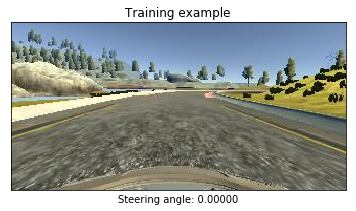

In [5]:
data = load_data(labels_file, 0.2)
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Training example"
display(image, steering_angle, label)

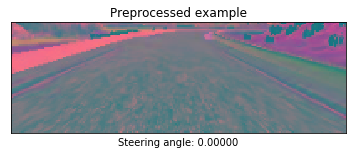

In [6]:
# the second step is  Data Preprocessing 
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
def preprocess(img):
    """
    Preprocessing (Crop - Resize - Convert to YUV) the input image.
        Parameters:
            img: The input image to be preprocessed.
    """
    # Cropping the image
    img = img[60:-25, :, :]
    # Resizing the image
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    # Converting the image to YUV
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return img
image = preprocess(load_image(data_dir, str(data[0][0][0])))
steering_angle = data[2][0]
label = "Preprocessed example"
display(image, steering_angle, label)

In [7]:
# the second step is Data Augmentation
def random_adjust(data_dir, center, left, right, steering_angle):
    """
    Adjusting the steering angle of random images.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle of the input frame.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load_image(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load_image(data_dir, right), steering_angle - 0.2
    return load_image(data_dir, center), steering_angle
def random_flip(image, steering_angle):
    """
    Randomly flipping the input image horizontaly, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

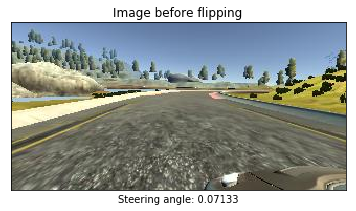

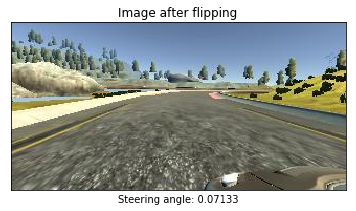

In [8]:
image = load_image(data_dir, str(data[0][0][1]))
steering_angle = data[2][1]
label = "Image before flipping"
display(image, steering_angle, label)

image = random_flip(image, steering_angle)
label = "Image after flipping"
display(image[0], image[1], label)

In [9]:
def random_shift(image, steering_angle, range_x, range_y):
    """
    Shifting (Translating) the input images, with steering angle adjustment.
        Parameters:
            image: The input image.
            steering_angle: The steering angle related to the input image.
            range_x: Horizontal translation range.
            range_y: Vertival translation range.
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

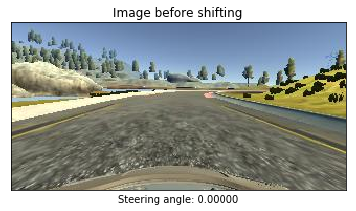

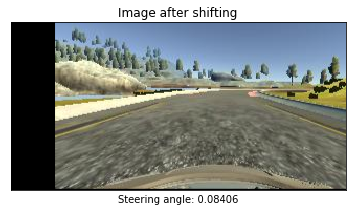

In [10]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before shifting"
display(image, steering_angle, label)

image = random_shift(image, steering_angle, 100, 10)
label = "Image after shifting"
display(image[0], image[1], label)

In [11]:
def random_shadow(image):
    """
    Adding shadow to the input image.
        Parameters:
            image: The input image.
    """
    bright_factor = 0.3
    x = random.randint(0, image.shape[1])
    y = random.randint(0, image.shape[0])
    width = random.randint(image.shape[1], image.shape[1])
    if(x + width > image.shape[1]):
        x = image.shape[1] - x
    height = random.randint(image.shape[0], image.shape[0])
    if(y + height > image.shape[0]):
        y = image.shape[0] - y
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    image[y:y+height,x:x+width,2] = image[y:y+height,x:x+width,2]*bright_factor
    return cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

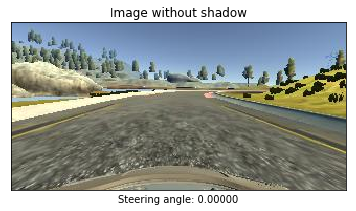

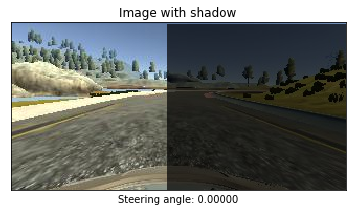

In [12]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image without shadow"
display(image, steering_angle, label)

image = random_shadow(image)
label = "Image with shadow"
display(image, steering_angle, label)

In [13]:
def random_brightness(image):
    """
    Altering the brightness of the input image.
        Parameters:
            image: The input image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

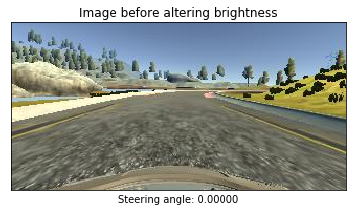

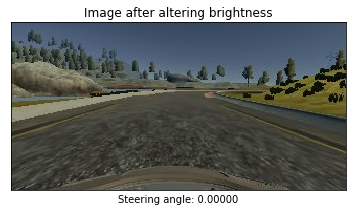

In [14]:
image = load_image(data_dir, str(data[0][0][0]))
steering_angle = data[2][0]
label = "Image before altering brightness"
display(image, steering_angle, label)

image = random_brightness(image)
label = "Image after altering brightness"
display(image, steering_angle, label)

In [15]:
def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust the associated steering angle.
        Parameters:
            data_dir: The directory where the images are.
            center: Center image.
            left: Left image.
            right: Right image
            steering_angle: The steering angle related to the input frame.
            range_x (Default = 100): Horizontal translation range.
            range_y (Default = 10): Vertival translation range.
    """
    image, steering_angle = random_adjust(data_dir, center, left, right, steering_angle)
    image, steering_angle = random_flip(image, steering_angle)
    image, steering_angle = random_shift(image, steering_angle, range_x, range_y)
    image = random_shadow(image)
    image = random_brightness(image)
    return image, steering_angle

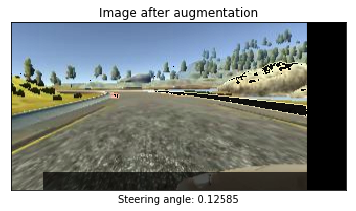

In [16]:
steering_angle = data[2][0]
center = data[0][0][0]
left = data[0][0][1]
right = data[0][0][2]
range_x = 100
range_y = 10

image, steering_angle = augument(data_dir, center, left, right, steering_angle, range_x, range_y)
label = "Image after augmentation"
display(image, steering_angle, label)

In [18]:
# the third Model Architecture
def NVIDIA_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(36, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(48, 5, 5, activation='relu', subsample=(2, 2)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.summary()
    return model

In [21]:
# the fourth Training the Model 
batch_size = 20
samples_per_epoch = 2000
nb_epoch = 10
def batcher(data_dir, image_paths, steering_angles, batch_size, training_flag):
    """
    Generate a training image given image paths and the associated steering angles
        Parameters:
            data_dir: The directory where the images are.
            image_paths: Paths to the input images.
            steering_angle: The steering angle related to the input frame.
            batch_size: The batch size used to train the model.
            training_flag: A flag to determine whether we're in training or validation mode.
    """
    images = np.empty([batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    steers = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            if training_flag and np.random.rand() < 0.6:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load_image(data_dir, center) 
            images[i] = preprocess(image)
            steers[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        yield images, steers
        
def train_model(model, X_train, X_valid, y_train, y_valid):
    checkpoint = ModelCheckpoint('model-{val_loss:03f}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
    model.compile(loss='mse', optimizer=Adam(lr=1.0e-4))
    model.fit_generator(batcher(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch,
                        nb_epoch,
                        max_q_size=1,
                        validation_data=batcher(data_dir, X_valid, y_valid, batch_size, False),
                        nb_val_samples=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)

In [22]:
model = NVIDIA_model()
train_model(model, *data)

C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", strides=(2, 2))`
  """
C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  
C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  import sys
C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 18, 64)         0         
__________

C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\Users\river\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 2000, 10, validation_data=<generator..., callbacks=[<keras.ca..., verbose=1, validation_steps=1608, max_queue_size=1)`


Epoch 1/10
2000/2000 [==============================] - 1251s 625ms/step - loss: 0.0243 - val_loss: 0.0109
Epoch 2/10
2000/2000 [==============================] - 939s 469ms/step - loss: 0.0179 - val_loss: 0.0101
Epoch 3/10
2000/2000 [==============================] - 809s 405ms/step - loss: 0.0165 - val_loss: 0.0098
Epoch 4/10
2000/2000 [==============================] - 712s 356ms/step - loss: 0.0154 - val_loss: 0.0099
Epoch 5/10
2000/2000 [==============================] - 685s 342ms/step - loss: 0.0147 - val_loss: 0.0095
Epoch 6/10
2000/2000 [==============================] - 652s 326ms/step - loss: 0.0143 - val_loss: 0.0098
Epoch 7/10
2000/2000 [==============================] - 1096s 548ms/step - loss: 0.0142 - val_loss: 0.0098
Epoch 8/10
2000/2000 [==============================] - 1395s 697ms/step - loss: 0.0135 - val_loss: 0.0091
Epoch 9/10
2000/2000 [==============================] - 981s 490ms/step - loss: 0.0135 - val_loss: 0.0093
Epoch 10/10
2000/2000 [====================

In [23]:
model.save('model.h5')


## Step 5: Model Testing on the simulator
The model was able to drive the car safely through the track without leaving the drivable portion of the track surface.

---
## Conclusion

Using NVIDIA's End to End learning network, the model was able to drive the car through the first track. I've only used the training data provided by Udacity.
One way to improve the model is to collect more data from the mountain track, and train the model to go through this challenging track as well.
We can also modify `drive.py` script to change the maximum speed and make it related to the steering angle, in order to make the car speed up in the straight parts of the track, and slow down in the curved parts.